In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

### Feature Engineering with Convolution Images.

In [3]:
def conv2d(image, kernel):
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape

    output_h = image_h - kernel_h + 1
    output_w = image_w - kernel_w + 1
    
    output = np.zeros((output_h, output_w)) 

    for i in range(output_h):
        for j in range(output_w):
            region = image[i:i + kernel_h, j:j + kernel_w]
            output[i, j] = np.sum(region * kernel)
    return output

def apply_conv(dataset, kernel):
    output_dataset = np.zeros((dataset.shape[0], 
                                dataset.shape[1] - kernel.shape[0] + 1, 
                                dataset.shape[2] - kernel.shape[1] + 1))
    for idx in range(dataset.shape[0]):
        output_dataset[idx] = conv2d(dataset[idx], kernel)
    return output_dataset

kernel = np.array([[0.2, 0.1, 0.4],
                   [0.5, 0.3, 0.2],
                   [0.3, 0.2, 0.5]])

In [3]:
x_train_conv = apply_conv(x_train, kernel=kernel)
x_test_conv = apply_conv(x_test, kernel=kernel)

In [4]:
x_train = x_train_conv.reshape(-1, x_train_conv.shape[1] * x_train_conv.shape[2]).astype('float32') / 255.0
x_test = x_test_conv.reshape(-1, x_test_conv.shape[1] * x_test_conv.shape[2]).astype('float32') / 255.0
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [5]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.97


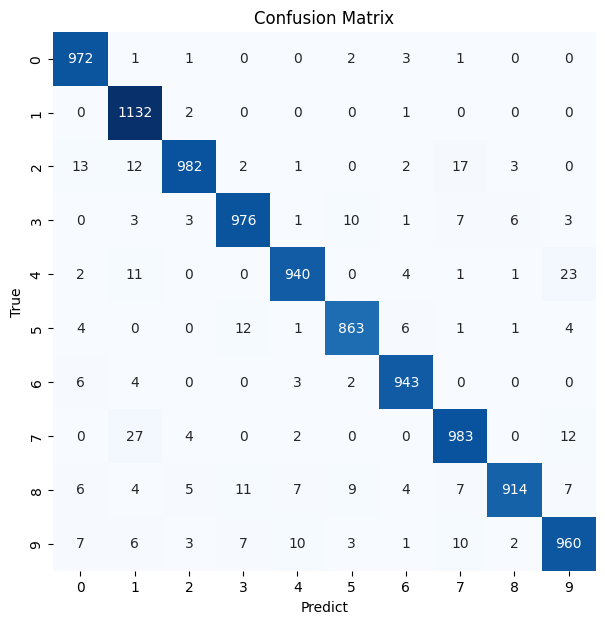

In [6]:
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predict')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [7]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

precision_ = precision_score(y_test, y_pred, average='weighted')
recall_ = recall_score(y_test, y_pred, average='weighted')
f1_ = f1_score(y_test, y_pred, average='weighted')

accuracy_ = accuracy_score(y_test, y_pred)

_metrics = {
    'Precision': precision_,
    'Recall': recall_,
    'F1-Score': f1_,
    'Accuracy': accuracy_
}

df_matrix = pd.DataFrame([_metrics])
print("Classification Report")
df_matrix

Classification Report


,Precision,Recall,F1-Score,Accuracy
0,0.96681,0.9665,0.966457,0.9665


In [8]:
hyp_knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [1, 2, 5, 10],    
    'weights': ['uniform', 'distance'], 
    'algorithm': {'auto', 'ball_tree', 'kd_tree', 'brute'}
}

In [ ]:
grid_search = GridSearchCV(hyp_knn, param_grid, cv=3, verbose=1, n_jobs=-1)
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [ ]:
print("Best parameters found: ", grid_search.best_params_)

In [ ]:
best_knn = grid_search.best_estimator_
y_pred1 = best_knn.predict(x_test)

accuracy1 = accuracy_score(y_test, y_pred1)
print(f"Test Accuracy: {accuracy1:.2f}")

In [ ]:
results_knn = pd.DataFrame(grid_search.cv_results_['params'])
results_knn['mean_test_score'] = grid_search.cv_results_['mean_test_score']
filtered_results = results_knn[(results_knn['weights'] == 'uniform') & (results_knn['algorithm'] == 'auto')]
plt.plot(filtered_results['n_neighbors'], filtered_results['mean_test_score'], marker='o')

plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Cross Validation Score')
plt.title('KNN Performance Comparison (weights=uniform, algorithm=auto)')
plt.show()

In [ ]:
confusm = tf.math.confusion_matrix(y_test, y_pred1)

plt.figure(figsize=(7, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predict')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision_1 = precision_score(y_test, y_pred1, average='weighted')
recall_1 = recall_score(y_test, y_pred1, average='weighted')
f1_1 = f1_score(y_test, y_pred1, average='weighted')

accuracy_1 = accuracy_score(y_test, y_pred1)

_metrics1 = {
    'Precision': precision_1,
    'Recall': recall_1,
    'F1-Score': f1_1,
    'Accuracy': accuracy_1
}

df_matrix1 = pd.DataFrame([_metrics1])
print("Classification Report")
df_matrix1

In [ ]:
def display_one_prediction(images, true_labels, pred_labels):
    correct = np.where(true_labels == pred_labels)[0]
    incorrect = np.where(true_labels != pred_labels)[0]

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    if len(correct) > 0:
        random_correct = np.random.choice(correct)
        axs[0].imshow(images[random_correct].reshape(28, 28), cmap='gray')
        axs[0].set_title(f"Correct\nPred: {pred_labels[random_correct]}, True: {true_labels[random_correct]}")
    else:
        axs[0].axis('off')

    if len(incorrect) > 0:
        random_incorrect = np.random.choice(incorrect)
        axs[1].imshow(images[random_incorrect].reshape(28, 28), cmap='gray')
        axs[1].set_title(f"Incorrect\nPred: {pred_labels[random_incorrect]}, True: {true_labels[random_incorrect]}")
    else:
        axs[1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
x_test_reshaped_inverted = x_test.reshape(-1, x_train_conv.shape[1], x_train_conv.shape[2])

In [ ]:
display_one_prediction(x_test_reshaped_inverted, y_test, y_pred1)

In [ ]:
import os

directory = "model"

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory '{directory}' created.")
else:
    print(f"Directory '{directory}' already exists.")

In [ ]:
import joblib

joblib.dump(best_knn, 'model/knn_mnist_model.pkl')